## Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import random
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection, model_selection, metrics

#visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
data_raw = pd.read_csv(r'datasets/titanic/train.csv')
data_val = pd.read_csv(r'datasets/titanic/test.csv')
data1 = data_raw.copy(deep = True)
data_cleaner = [data1, data_val]
print(data_raw.info())
data_raw.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print('Train columns with null values:', data1.isnull().sum())
print("-"*10)
print('Test/Validation columns with null values:', data_val.isnull().sum())
data1.describe(include = 'all')

Train columns with null values: PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values: PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Andersson, Miss. Erna Alexandra",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
for dataset in data_cleaner:
    #complete missing age with median
    dataset.Age.fillna(dataset.Age.median(), inplace = True)
    
    #complete embarked with mode
    dataset.Embarked.fillna(dataset.Embarked.mode()[0], inplace = True)
    
    #complete missing fare with median
    dataset.Fare.fillna(dataset.Fare.median(), inplace = True)

data1.drop(['PassengerId', 'Cabin', 'Ticket'], inplace = True, axis =1 )
print(data1.isnull().sum())
print('-' * 10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [5]:
#check all titles
def find_title(x):
    if x.find(',') and x.find('.') > -1:
        return x[x.find(',')+2:x.find('.')]
    else: return np.nan

def replace_titles(df):
    x = df['Title']
    if x in ['Lady', 'the Countess', 'Mme', 'Dona']:
        return 'Mrs'
    elif x in ['Major', 'Rev', 'Jonkheer', 'Col', 'Capt', 'Don', 'Sir']:
        return 'Mr'
    elif x in ['Mlle', 'Ms']:
        return 'Miss'
    elif x == 'Dr':
        if df['Sex'] == 'female':
            return 'Mrs'
        else: return 'Mr'
    else: return x


# feature ingeneering

for dataset in data_cleaner:
    dataset['FamilySize'] = dataset.SibSp + dataset.Parch + 1
    dataset['IsAlone'] = 1
    dataset.IsAlone[dataset['FamilySize'] > 1 ] = 0
    dataset['Title'] = dataset.Name.apply(find_title)
    dataset['Title'] = dataset.apply(replace_titles, axis = 1)
    dataset['FareBin'] = pd.qcut(dataset.Fare,4) #because normally distributed?
    dataset['AgeBin'] = pd.cut(dataset.Age.astype(int),5) #

In [6]:
print(data1.Title.value_counts() < 10)
print('-' * 35)
print(data1.info())
print('-' * 35)
print(data_val.info())
data1.head()

Mr        False
Miss      False
Mrs       False
Master    False
Name: Title, dtype: bool
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null object
Age           891 non-null float64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      891 non-null object
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Title         891 non-null object
FareBin       891 non-null category
AgeBin        891 non-null category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.5+ KB
None
-----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"


In [7]:
# convert categorical labels to dummy variables

label = LabelEncoder()

for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])
    
Target = ['Survived']

# define x variables fro original feature selection

data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x
print('Original X Y: ', data1_xy, '\n')

# define x variables for original w/bin features to remove continious variables
data1_x_bin = ['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'AgeBin_Code', 'FareBin_Code', 'FamilySize']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')

# define x and y for variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = data1_x_dummy + Target
print('Dummy X Y: ', data1_xy_dummy, '\n')

data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'AgeBin_Code', 'FareBin_Code', 'FamilySize'] 

Dummy X Y:  ['Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Survived'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,1,0


In [8]:
print(data1.isnull().sum())
print('-'*20)
print(data1.info())
print('-'*20)
print(data_val.isnull().sum())
print('-'*20)
print(data_val.info())

Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null object
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
Embarked         891 non-null object
FamilySize       891 non-null int64
IsAlone          891 non-null int64
Title            891 non-null object
FareBin          891 non-null category
AgeBin           891 

In [9]:
# split test and train data

train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

In [10]:
print('train1_x shape',data1.shape)
print('test1_x shape',test1_x.shape)
print('train1_x shape',train1_x.shape)

train1_x shape (891, 19)
test1_x shape (223, 8)
train1_x shape (668, 8)


In [11]:
data1[['Sex', Target[0]]].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [12]:
#simple analysis of variables on survival rate

for x in data1_x:
    if data1[x].dtype != 'float64':
        print('Survival Correlation by: ', x)
        print(data1[[x, Target[0]]].groupby(x).mean())
        print('-' * 10)

Survival Correlation by:  Sex
        Survived
Sex             
female  0.742038
male    0.188908
----------
Survival Correlation by:  Pclass
        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
----------
Survival Correlation by:  Embarked
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.339009
----------
Survival Correlation by:  Title
        Survived
Title           
Master  0.575000
Miss    0.702703
Mr      0.160149
Mrs     0.798450
----------
Survival Correlation by:  SibSp
       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000
----------
Survival Correlation by:  Parch
       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000
----------
Survival Correlation by:  FamilySize
            Survived
FamilySize          
1           0.303538
2 

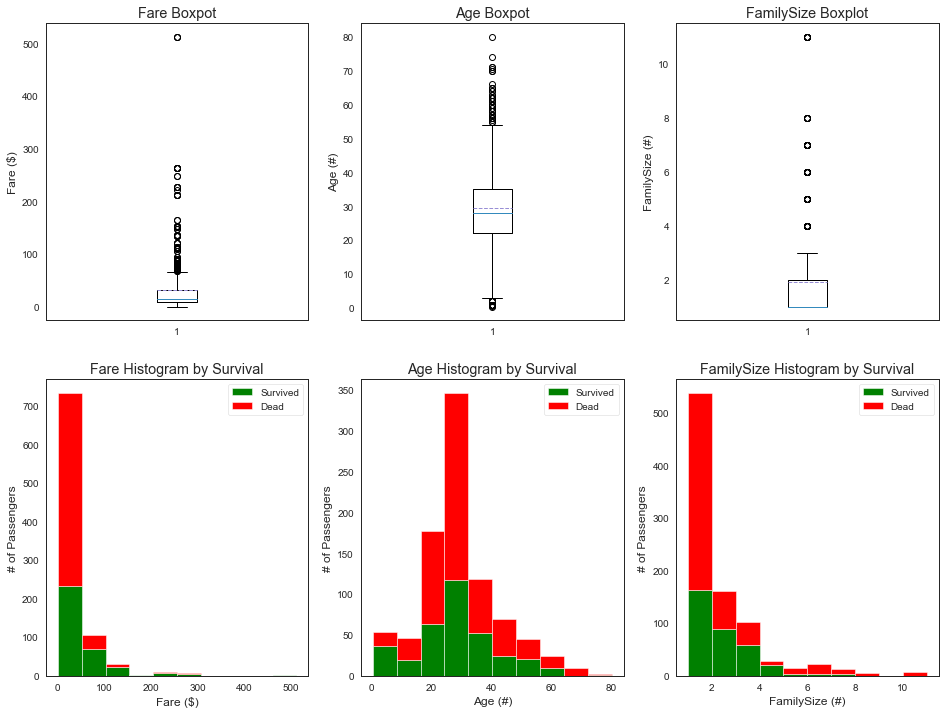

In [13]:
# some visualizations
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x = data1['Fare'], showmeans=True, meanline=True)
plt.title('Fare Boxpot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(x = data1['Age'], showmeans=True, meanline=True)
plt.title('Age Boxpot')
plt.ylabel('Age (#)')

plt.subplot(233)
plt.boxplot(x = data1['FamilySize'], showmeans=True, meanline=True)
plt.title('FamilySize Boxplot')
plt.ylabel('FamilySize (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived'] == 1]['Fare'], data1[data1['Survived'] == 0]['Fare']], stacked=True, color = ['g','r'],
        label = ['Survived', 'Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived'] == 1]['Age'], data1[data1['Survived'] == 0]['Age']], stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (#)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived'] == 1]['FamilySize'], data1[data1['Survived'] == 0]['FamilySize']], stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('FamilySize Histogram by Survival')
plt.xlabel('FamilySize (#)')
plt.ylabel('# of Passengers')
plt.legend()
plt.show()


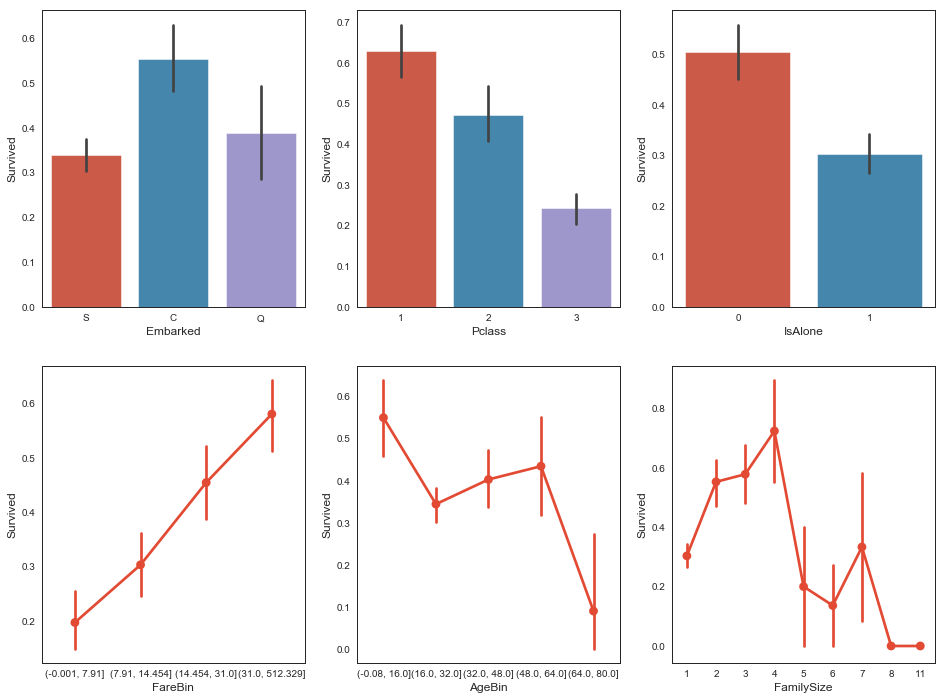

In [15]:
fig, saxis = plt.subplots(2,3, figsize=[16,12])

sns.barplot(x = 'Embarked', y = 'Survived', data = data1, ax = saxis[0,0])
sns.barplot(x = 'Pclass', y = 'Survived', data = data1, ax = saxis[0,1])
sns.barplot(x = 'IsAlone', y = 'Survived', data = data1, ax = saxis[0,2])
sns.pointplot(x = 'FareBin', y = 'Survived', data = data1 , ax = saxis[1,0])
sns.pointplot(x = 'AgeBin', y = 'Survived', data = data1, ax = saxis[1,1])
sns.pointplot(x = 'FamilySize', y = 'Survived', data = data1, ax = saxis[1,2])
plt.show()

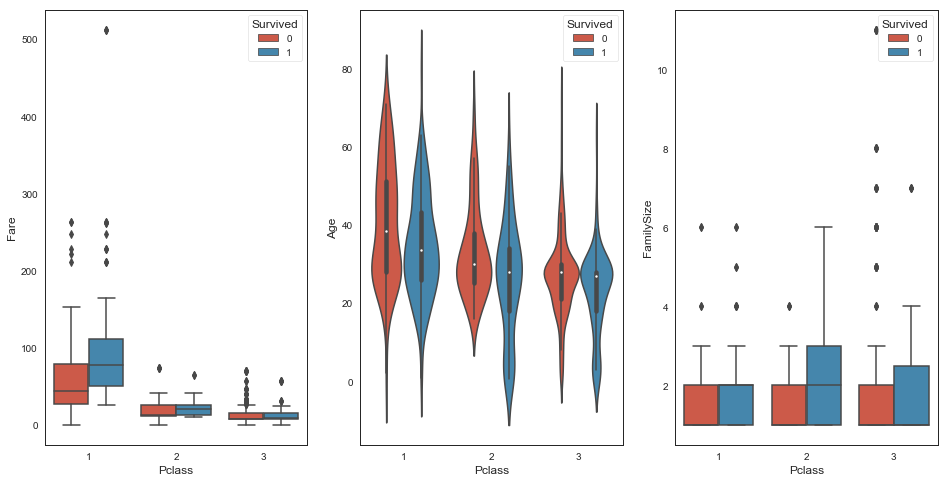

In [16]:
fig, axis = plt.subplots(1,3, figsize=[16,8])

sns.boxplot(x = 'Pclass', y = 'Fare',hue = 'Survived', data = data1, ax = axis[0])
sns.violinplot(x = 'Pclass', y = 'Age',hue = 'Survived', data = data1, ax = axis[1])
sns.boxplot(x = 'Pclass', y = 'FamilySize',hue = 'Survived', data = data1, ax = axis[2])
plt.show()

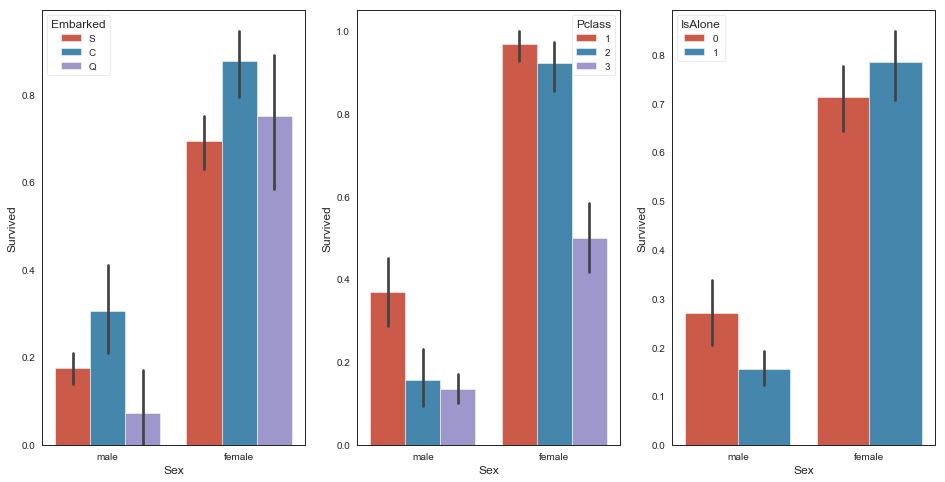

In [17]:
fig, axis = plt.subplots(1,3, figsize = [16,8])
sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data = data1, ax = axis[0])
sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data = data1, ax = axis[1])
sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data = data1, ax = axis[2])
plt.show()

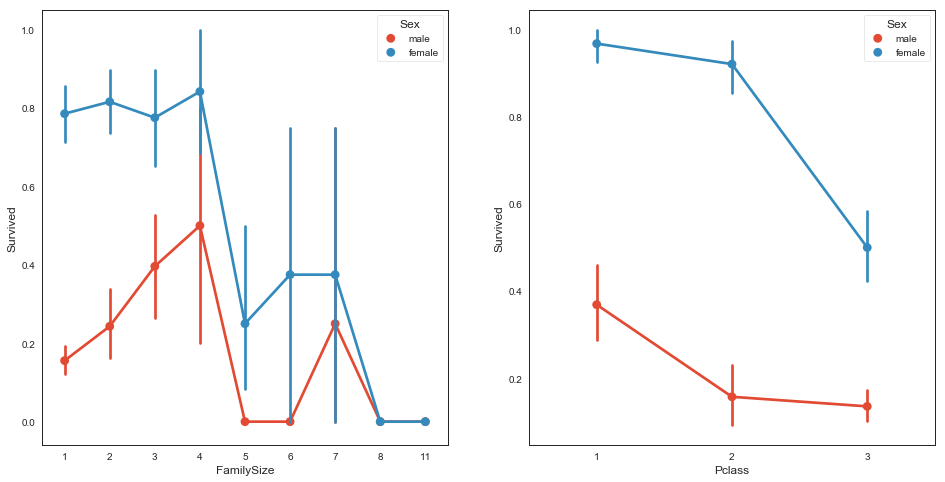

In [18]:
fig, axis = plt.subplots(1,2, figsize = [16,8])
sns.pointplot(x = 'FamilySize', y = 'Survived', hue = 'Sex', data = data1, ax = axis[0])
sns.pointplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = data1, ax = axis[1])
plt.show()

C:\Users\spiris\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\spiris\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


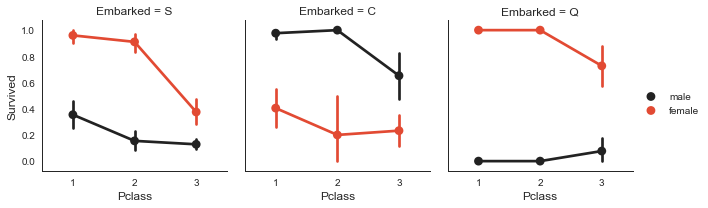

In [19]:
e = sns.FacetGrid(data1, col = 'Embarked')
e.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', ci=95, palete = 'deep')
e.add_legend()
plt.show()

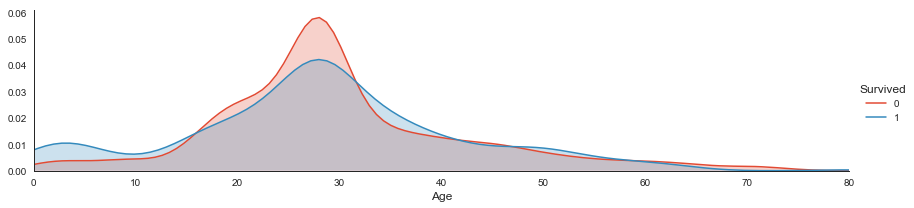

In [20]:
a = sns.FacetGrid(data1 , hue = 'Survived', aspect = 4)
a.map(sns.kdeplot, 'Age', shade = True)
a.set(xlim=[0, data1.Age.max()])
a.add_legend()
plt.show()

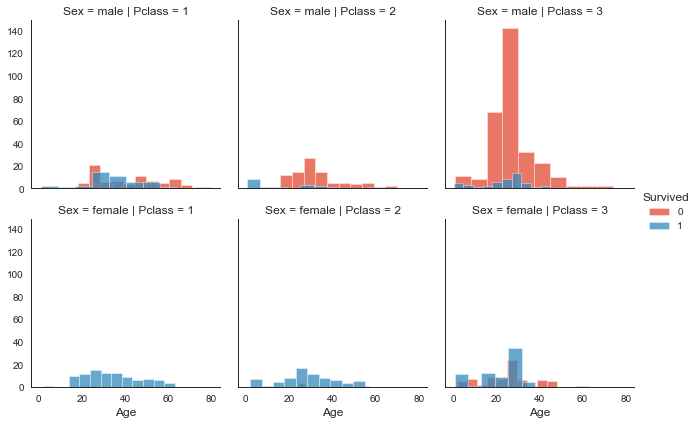

In [21]:
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map(plt.hist, 'Age', alpha = 0.75)
h.add_legend()
plt.show()

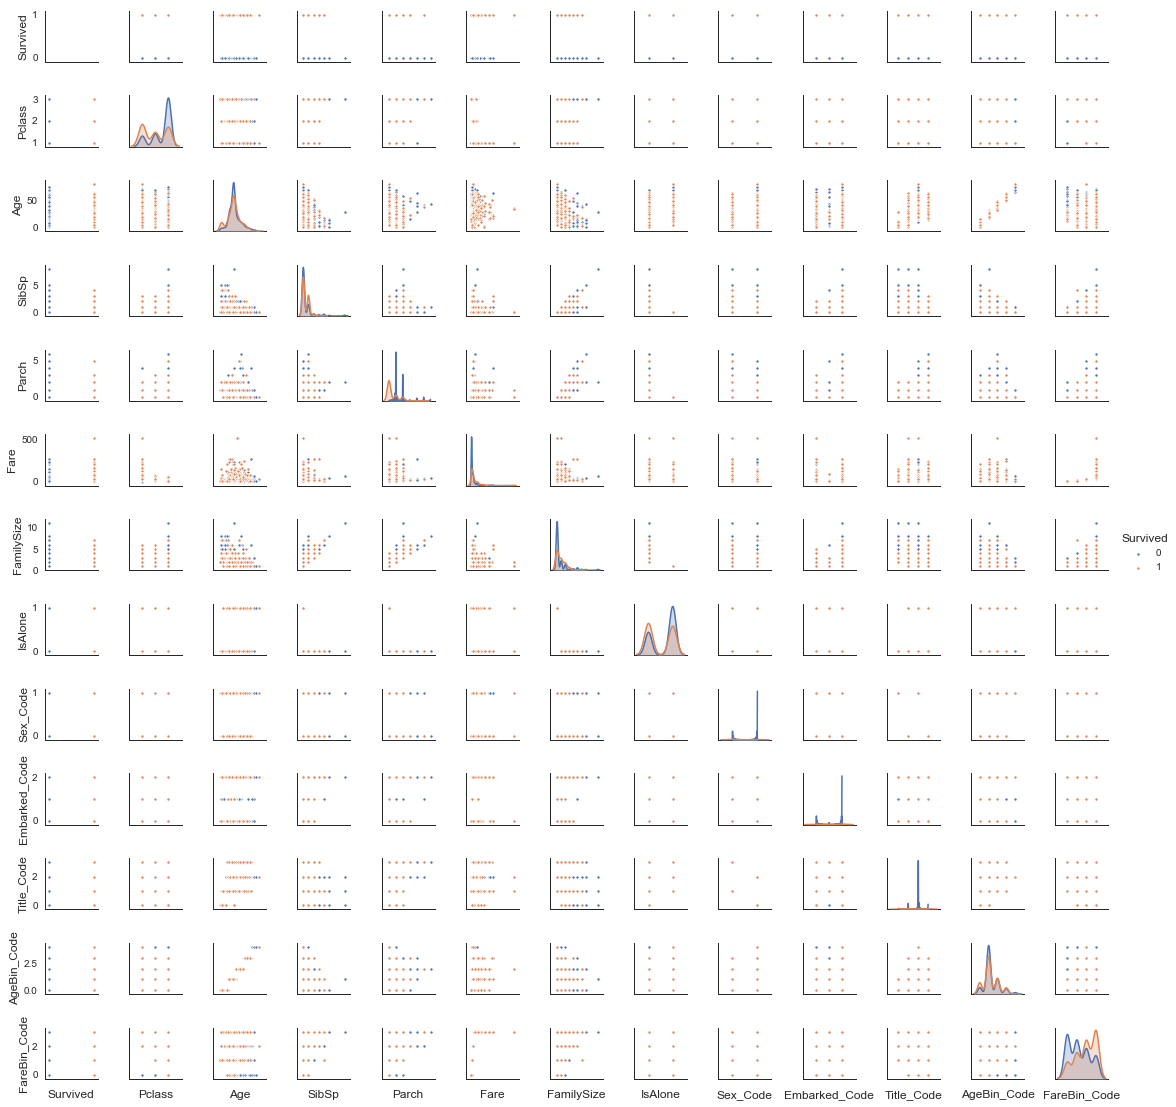

In [22]:
pp = sns.pairplot(data1, height=1.2, hue = 'Survived', palette = 'deep', diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pp.set(xticklabels=[])
plt.show()


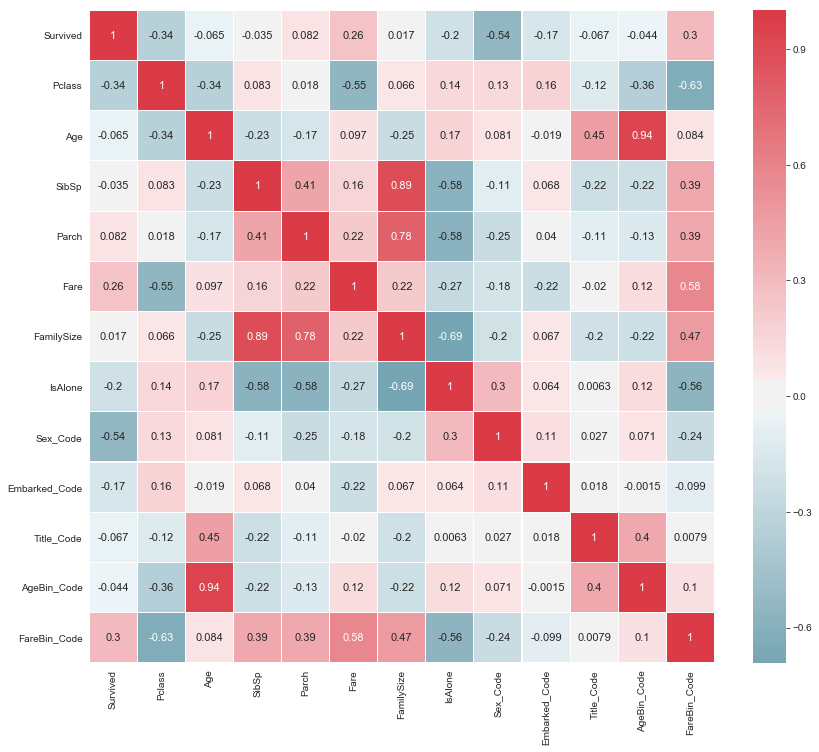

In [23]:
def correlantion_heatmap(df, center = None):
    
    fig, ax = plt.subplots(figsize = [14,12])
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    fig = sns.heatmap(df.corr(),
                cmap = colormap,
               center = center,
                annot = True,
                linewidths = 0.1,
                annot_kws={'fontsize':11}
               )
    
    
correlantion_heatmap(data1, center=0)

In [1]:
#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(max_iter = 100000),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target[0]], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target[0]])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1
    
    
MLA_compare.sort_values('MLA Test Accuracy Mean', ascending = False, inplace = True)
MLA_compare

NameError: name 'ensemble' is not defined

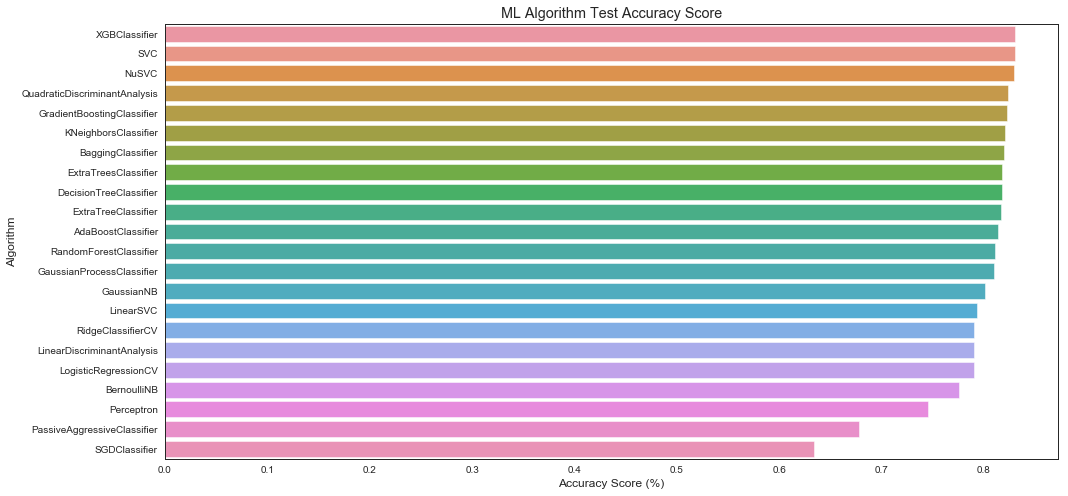

In [25]:
fig, ax = plt.subplots(figsize = [16,8])

sns.barplot(x = 'MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare)
plt.title('ML Algorithm Test Accuracy Score')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.show()

In [26]:
pivot_female = data1[data1.Sex == 'female'].groupby(by=['Pclass','Embarked', 'FareBin'])['Survived'].mean()
print(pivot_female)

pivot_male = data1[data1.Sex == 'male'].groupby(by=['Title'])['Survived'].mean()
print(pivot_male)

Pclass  Embarked  FareBin        
1       C         (14.454, 31.0]     0.666667
                  (31.0, 512.329]    1.000000
        Q         (31.0, 512.329]    1.000000
        S         (14.454, 31.0]     1.000000
                  (31.0, 512.329]    0.955556
2       C         (7.91, 14.454]     1.000000
                  (14.454, 31.0]     1.000000
                  (31.0, 512.329]    1.000000
        Q         (7.91, 14.454]     1.000000
        S         (7.91, 14.454]     0.875000
                  (14.454, 31.0]     0.916667
                  (31.0, 512.329]    1.000000
3       C         (-0.001, 7.91]     1.000000
                  (7.91, 14.454]     0.428571
                  (14.454, 31.0]     0.666667
        Q         (-0.001, 7.91]     0.750000
                  (7.91, 14.454]     0.500000
                  (14.454, 31.0]     0.714286
        S         (-0.001, 7.91]     0.533333
                  (7.91, 14.454]     0.448276
                  (14.454, 31.0]     0.357143


In [27]:
def mytree(df):
    if (df.Sex == 'male') & (df.Title == 'Master'):
        return 1
    elif (df.Sex == 'female') & (df.Pclass in [1,2]):
        return 1
    elif (df.Sex == 'female') & (df.Pclass == 3) & (df.Embarked in ['C', 'Q']):
        return 1
    else: return 0
        
Tree_Predict  = data1.apply(mytree, axis = 1)
(Tree_Predict  == data1.Survived).mean()

0.8181818181818182

Confusion matrix, without normalization
[[506  43]
 [119 223]]
Normalized confusion matrix
[[0.92 0.08]
 [0.35 0.65]]


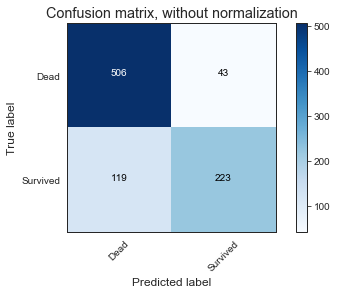

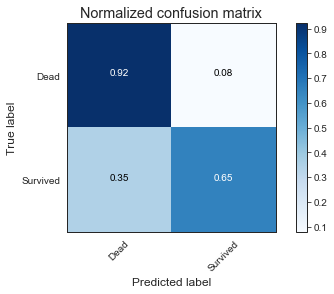

In [28]:
#Plot Accuracy Summary
#Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(data1['Survived'], Tree_Predict)
np.set_printoptions(precision=2)

class_names = ['Dead', 'Survived']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, 
                      title='Normalized confusion matrix')

In [29]:
# Parameter selection

#before
dtree = tree.DecisionTreeClassifier(random_state=0)
base_results = model_selection.cross_validate(dtree, data1[data1_x_bin], data1[Target[0]], cv  = cv_split)
dtree.fit(data1[data1_x_bin], data1[Target[0]])

print('BEFORE DT Parameters: ', dtree.get_params())
print('BEFORE DT Training w/bin score mean: %.2f' % (base_results['train_score'].mean() * 100))
print('BEFORE DT Test w/bin score mean: %.2f' % (base_results['test_score'].mean() * 100))
print('BEFORE DT Test w/bin score 3*std: +/- %.2f' % (base_results['test_score'].std() *100 * 3))
print('-' * 40)


#after
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth':[2,4,6,8,10,None],
    'random_state' :[0]}

tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid = param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(data1[data1_x_bin], data1[Target[0]])

print('AFTER DT Parameters: ', tune_model.best_params_)
print('AFTER DT Training w/bin score mean: %.2f' % (tune_model.cv_results_['mean_train_score'].mean() * 100))
print('AFTER DT Test w/bin score mean: %.2f' % (tune_model.cv_results_['mean_test_score'].mean() * 100))
print('AFTER DT Test w/bin score 3*std: +/- %.2f' % (tune_model.cv_results_['mean_test_score'].std() * 100 * 3))
print('-' * 40)

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 89.06
BEFORE DT Test w/bin score mean: 81.72
BEFORE DT Test w/bin score 3*std: +/- 6.92
----------------------------------------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 91.57
AFTER DT Test w/bin score mean: 84.10
AFTER DT Test w/bin score 3*std: +/- 5.77
----------------------------------------


In [30]:
# Feature selection

#before
print('BEFORE DT RFE Training Shape Old: ', data1[data1_x_bin].shape)
print('BEFORE DT RFE Training Columns Old: ', data1[data1_x_bin].columns)
print('BEFORE DT RFE Training w/bin score mean: %.2f' % (base_results['train_score'].mean() * 100))
print('BEFORE DT RFE Test w/bin score mean: %.2f' % (base_results['test_score'].mean() * 100))
print('BEFORE DT RFE Test w/bin score 3*std: +/- %.2f' % (base_results['test_score'].std() *100 * 3))
print('-' * 40)

#after
dtree_rfe  = feature_selection.RFECV(dtree, step=1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(data1[data1_x_bin], data1[Target[0]])

X_rfe = data1[data1_x_bin].columns[dtree_rfe.support_]
rfe_results = model_selection.cross_validate(dtree, data1[X_rfe], data1[Target[0]], cv = cv_split)

print('AFTER DT RFE Training Shape Old: ', data1[X_rfe].shape)
print('AFTER DT RFE Training Columns Old: ', X_rfe)
print('AFTER DT RFE Training w/bin score mean: %.2f' % (rfe_results['train_score'].mean() * 100))
print('AFTER DT RFE Test w/bin score mean: %.2f' % (rfe_results['test_score'].mean() * 100))
print('AFTER DT RFE Test w/bin score 3*std: +/- %.2f' % (rfe_results['test_score'].std() *100 * 3))
print('-' * 40)

#tune + right predictors
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid = param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(data1[X_rfe], data1[Target[0]])

print('AFTER DT Parameters: ', rfe_tune_model.best_params_)
print('AFTER DT Training w/bin score mean: %.2f' % (rfe_tune_model.cv_results_['mean_train_score'].mean() * 100))
print('AFTER DT Test w/bin score mean: %.2f' % (rfe_tune_model.cv_results_['mean_test_score'].mean() * 100))
print('AFTER DT Test w/bin score 3*std: +/- %.2f' % (rfe_tune_model.cv_results_['mean_test_score'].std() * 100 * 3))
print('-' * 40)


BEFORE DT RFE Training Shape Old:  (891, 7)
BEFORE DT RFE Training Columns Old:  Index(['Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'AgeBin_Code',
       'FareBin_Code', 'FamilySize'],
      dtype='object')
BEFORE DT RFE Training w/bin score mean: 89.06
BEFORE DT RFE Test w/bin score mean: 81.72
BEFORE DT RFE Test w/bin score 3*std: +/- 6.92
----------------------------------------
AFTER DT RFE Training Shape Old:  (891, 6)
AFTER DT RFE Training Columns Old:  Index(['Sex_Code', 'Pclass', 'Title_Code', 'AgeBin_Code', 'FareBin_Code',
       'FamilySize'],
      dtype='object')
AFTER DT RFE Training w/bin score mean: 87.43
AFTER DT RFE Test w/bin score mean: 82.57
AFTER DT RFE Test w/bin score 3*std: +/- 5.80
----------------------------------------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 90.94
AFTER DT Test w/bin score mean: 85.26
AFTER DT Test w/bin score 3*std: +/- 4.84
---------------------------------

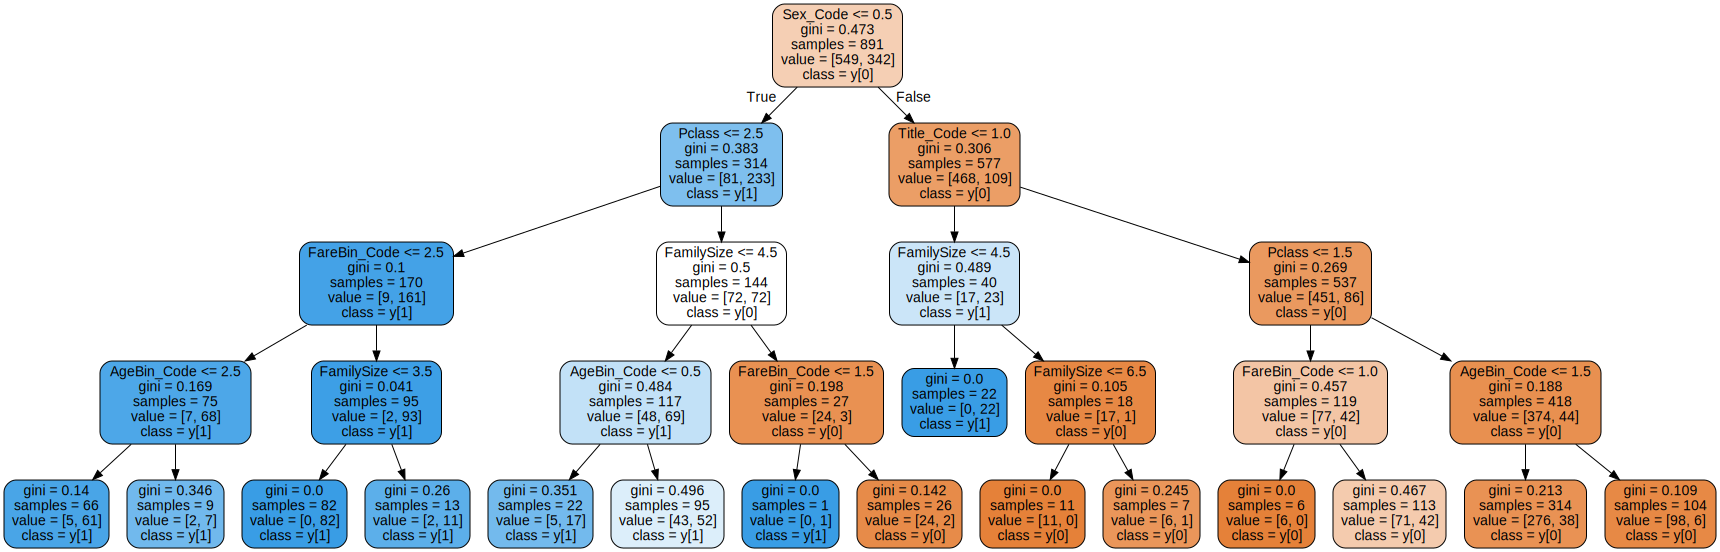

In [31]:
dtree1 = tree.DecisionTreeClassifier(**tune_model.best_params_)
dtree1.fit(data1[X_rfe], data1[Target[0]])


import os
os.environ['PATH'] += os.pathsep + r'C:\Users\spiris\.anaconda\navigator\graphviz-2.38\release\bin'

import graphviz 
dot_data = tree.export_graphviz(dtree1, out_file=None, 
                                feature_names = X_rfe, class_names = True,
                                filled = True, rounded = True, )
graph = graphviz.Source(dot_data)

graph #.view() to open as PDF

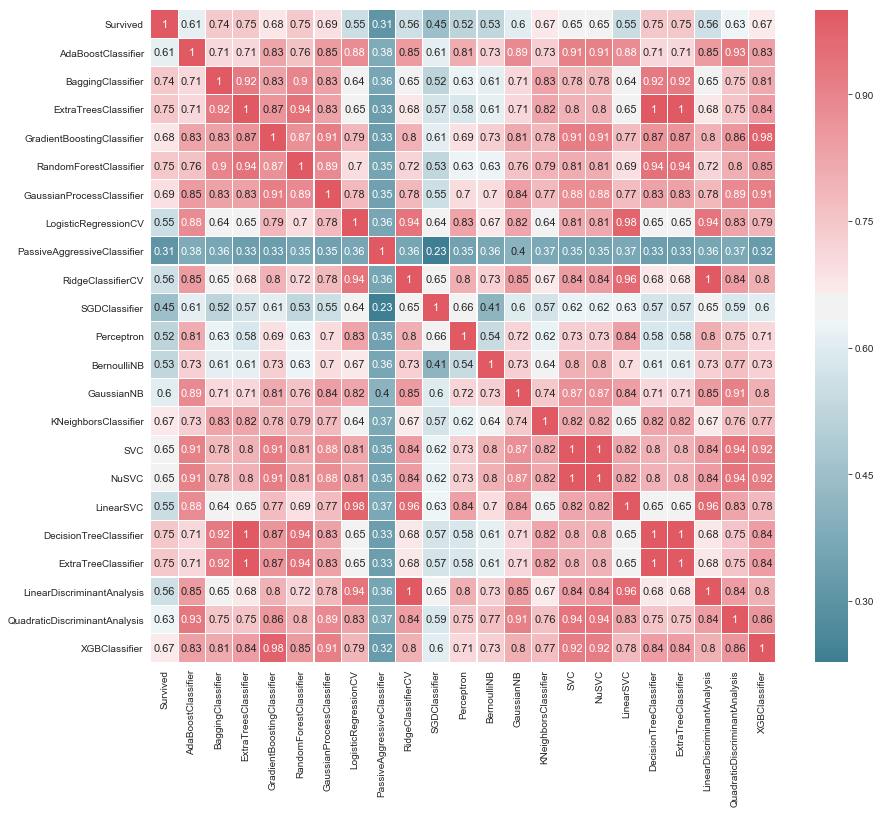

In [32]:
correlantion_heatmap(MLA_predict, center=0.65)

In [33]:
# voting classifier

vote_est = [
    #Ensemble Methods
    ('ada',ensemble.AdaBoostClassifier()),
    ('bc',ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc',ensemble.GradientBoostingClassifier()),
    ('rfc',ensemble.RandomForestClassifier()),

    #Gaussian Processes
    ('gpc',gaussian_process.GaussianProcessClassifier()),

    #GLM
    ('lr',linear_model.LogisticRegressionCV()),

    #Navies Bayes
    ('bnb',naive_bayes.BernoulliNB()),
    ('gnb',naive_bayes.GaussianNB()),

    #Nearest Neighbor
    ('knn',neighbors.KNeighborsClassifier()),

    #SVM
    ('svc',svm.SVC(probability=True)),

    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    ('xgb',XGBClassifier())  
]

# hard vote
vote_hard = ensemble.VotingClassifier(estimators=vote_est, voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, data1[data1_x_bin], data1[Target[0]], cv = cv_split)
vote_hard.fit(data1[data1_x_bin], data1[Target[0]])

print('Hard Voting Training w/bin score mean: %.2f' % (vote_hard_cv['train_score'].mean()*100))
print('Hard Voting Testing w/bin score mean: %.2f' % (vote_hard_cv['test_score'].mean()*100))
print('Hard Voting Testing w/bin score 3*std: +/- %.2f' % (vote_hard_cv['test_score'].std()*3*100))
print('-' * 40)

# soft vote

vote_soft = ensemble.VotingClassifier(estimators=vote_est, voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, data1[data1_x_bin], data1[Target[0]], cv = cv_split)
vote_soft.fit(data1[data1_x_bin], data1[Target[0]])

print('Soft Voting Training w/bin score mean: %.2f' % (vote_soft_cv['train_score'].mean()*100))
print('Soft Voting Testing w/bin score mean: %.2f' % (vote_soft_cv['test_score'].mean()*100))
print('Soft Voting Testing w/bin score 3*std: +/- %.2f' % (vote_soft_cv['test_score'].std()*3*100))
print('-' * 40)

Hard Voting Training w/bin score mean: 86.16
Hard Voting Testing w/bin score mean: 82.72
Hard Voting Testing w/bin score 3*std: +/- 3.13
----------------------------------------
Soft Voting Training w/bin score mean: 86.76
Soft Voting Testing w/bin score mean: 82.13
Soft Voting Testing w/bin score 3*std: +/- 3.48
----------------------------------------


In [55]:
# Hyperparameter tune for all models
grid_n_estimator = [10,50,100,300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2,4,6,8,10, None]
grid_max_samples = [5,10,.03,.05,.10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
    
    #('ada',ensemble.AdaBoostClassifier())
    [{'n_estimators':grid_n_estimator,
     'learning_rate':grid_learn,
     'random_state':grid_seed}],
    
    #('bc',ensemble.BaggingClassifier()),
    [{'n_estimators': grid_n_estimator, #default=10
    'max_samples': grid_ratio, #default=1.0
    'random_state': grid_seed}],
    
    #('etc',ensemble.ExtraTreesClassifier()),
    [{'n_estimators': grid_n_estimator, #default=10
    'criterion': grid_criterion, #default=”gini”
    'max_depth': grid_max_depth, #default=None
    'random_state': grid_seed}],
    
    #('gbc',ensemble.GradientBoostingClassifier()),
    [{'learning_rate': [.05],
     'n_estimators': [300],
      'max_depth': grid_max_depth,
      'random_state': grid_seed
     }],
    
    #('rfc',ensemble.RandomForestClassifier()),
    [{'n_estimators': [20,50,100,300], #default=10
    'criterion': grid_criterion, #default=”gini”
    'max_depth': grid_max_depth, #default=None
    'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
    'random_state': grid_seed}],

    #('gpc',gaussian_process.GaussianProcessClassifier()),
    [{'max_iter_predict': grid_n_estimator, #default: 100
    'random_state': grid_seed}],
    
    #('lr',linear_model.LogisticRegressionCV()),
    [{'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
    'random_state': grid_seed, 'max_iter': [1000]}],
    
    #('bnb',naive_bayes.BernoulliNB()),
    [{'alpha': grid_ratio}],
      
      
    #('gnb',naive_bayes.GaussianNB()),
    [{}],

    #('knn',neighbors.KNeighborsClassifier()),
    [{'n_neighbors': [1,2,3,4,5,6,7], #default: 5
    'weights': ['uniform', 'distance'], #default = ‘uniform’
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}],

    #('svc',svm.SVC(probability=True)),
    [{'C': [1,2,3,4,5], #default=1.0
    'gamma': grid_ratio, #edfault: auto
    'decision_function_shape': ['ovo', 'ovr'], #default:ovr
    'probability': [True],
    'random_state': grid_seed}],

    #('xgb',XGBClassifier()) 
    [{'learning_rate': grid_learn, #default: .3
    'max_depth': [1,2,4,6,8,10], #default 2
    'n_estimators': grid_n_estimator, 
    'seed': grid_seed}]
    
]

start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(data1[data1_x_bin], data1[Target[0]])
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_state': 0} with a runtime of 24.54 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 21.19 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 100, 'random_state': 0} with a runtime of 45.46 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 30.51 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 20, 'oob_score': True, 'random_state': 0} with a runtime of 52.94 seconds.
The best parameter for GaussianProcessClassifier is {'max_iter_predict': 10, 'random_state': 0} with a runtime of 7.68 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': True, 'max_iter': 1000

In [9]:
t = [10]
t.__class__.__name__

'list'

In [5]:
data_raw.profile_report()

AttributeError: 'DataFrame' object has no attribute 'profile_report'